This example shows how to use the function create_animation (found in modules/plotter.py) to create a mp4 or gif file animation of a time-lapse for 3D data. 

In [1]:
import xarray as xr
import numpy as np
from IPython.display import Video
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import cmocean
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
import matplotlib.animation as animation

import sys
sys.path.append('../modules')
import nclcmaps as nclc

In [2]:
plt.rcParams['animation.ffmpeg_path'] = '/home/dnash/miniconda3/envs/pyclivac/bin/ffmpeg'

In [3]:
import matplotlib.animation as manimation
# import ffmpeg
manimation.writers.list()
# manimation.writers['ffmpeg']

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']

In [4]:
## Choose case study
## get filenames for IVT and Precip
month = 'dec'
year = 2019
datelst = ['1212', '1213', '1214', '1215'] 

#### Choose extent 

ext1 = [-150., -100., 20., 50.] # extend of north pacific
ndegx=10. # how frequent grid lines are in x direction
ndegy=5.  # how frequent grid lines are in y direction
extname = 'npacific'
regrid_q = 20

figname = '{0}_{1}{2}'.format(extname, month, str(year))
print(figname)

npacific_dec2019


### Load data

In [5]:
ivt_filenames = []
prec_filenames = []

for i, monthday in enumerate(datelst):
    ivt_filenames.append('/data/downloaded/Reanalysis/ERA5/{0}/{2}/ERA5_{0}_{2}{1}.nc'.format('IVT', monthday, str(year)))
    prec_filenames.append('/data/downloaded/Reanalysis/ERA5/{0}/{2}/ERA5_{0}_{2}{1}.nc'.format('Precip', monthday, str(year)))

In [6]:
###########################
### IVT and PRECIP DATA ###
###########################
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))

# Open dataset using xarray
ivt = xr.open_mfdataset(ivt_filenames, preprocess=preprocess, combine='by_coords')
prec = xr.open_mfdataset(prec_filenames, preprocess=preprocess, combine='by_coords')


################################
### GEOPOTENTIAL HEIGHT DATA ###
################################

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(ext1[2], ext1[3]), longitude=slice(ext1[0], ext1[1]), level=250.)

# # Set filepath
# datdir = '/data/projects/Comet/cwp140/'
# filename = 'ERA5/era5_uvq_prs_{0}*.nc'.format(year)
# filepath_pattern = datdir + filename

# # Open dataset using xarray
# ds2 = xr.open_mfdataset(filepath_pattern, combine='by_coords')

# rename_dict_upper = {'z': 'H', 
#                      'latitude': 'lat',
#                      'longitude': 'lon'}

# ds2 = ds2.drop(labels=['q', 'u', 'v', 't'])
# ds2 = ds2.rename(rename_dict_upper) # rename variables to something easier to understand
# ds2 = ds2.reindex(lat=list(reversed(ds2.lat))) # make it so lats are -90 to 90
# ds2 = ds2.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]), level=250.)
# ds2 = ds2.assign(H=lambda ds2: ds2.H/(9.80665*10)) # convert to geopotential height (dam)
# ds2.H.attrs['long_name'] = '250 hPa Geopotential Heights'
# ds2.H.attrs['units'] = 'Geopotential Heights (dam)'

# merge ALL ds together
ds = xr.merge([ivt, prec])
ds

# clean ds
ds = ds.assign(prec_cum=lambda ds: ds.TP.cumsum(dim='time')) # calculate precipitation accumulation

# set these for the animation function
ds.IVT.attrs['long_name'] = 'IVT'
ds.IVT.attrs['units'] = 'IVT (kg m$^{-1}$ s$^{-1}$)'

ds.prec_cum.attrs['long_name'] = 'Accumulated Precipitation'
ds.prec_cum.attrs['units'] = 'Precipitation (mm)'
ds = ds.drop(labels=['IWV', 'TP'])
ds

<xarray.Dataset>
Dimensions:   (time: 96, lat: 121, lon: 201)
Coordinates:
  * time      (time) datetime64[ns] 2019-12-12 ... 2019-12-15T23:00:00
  * lat       (lat) float64 20.0 20.25 20.5 20.75 21.0 ... 49.25 49.5 49.75 50.0
  * lon       (lon) float64 -150.0 -149.8 -149.5 -149.2 ... -100.5 -100.2 -100.0
Data variables:
    IVT       (time, lat, lon) float64 dask.array<chunksize=(24, 121, 201), meta=np.ndarray>
    uIVT      (time, lat, lon) float64 dask.array<chunksize=(24, 121, 201), meta=np.ndarray>
    vIVT      (time, lat, lon) float64 dask.array<chunksize=(24, 121, 201), meta=np.ndarray>
    prec_cum  (time, lat, lon) float64 dask.array<chunksize=(24, 121, 201), meta=np.ndarray>
Attributes:
    Conventions:                CF-1/0
    history:                    Mon Jul 13 13:36:45 2020: /apps/nco-4.9.3_gnu...
    history_of_appended_files:  Mon Jul 13 13:36:45 2020: Appended file ERA5_...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

In [7]:
%%time
ds = ds.load()

CPU times: user 3.38 s, sys: 6.53 s, total: 9.91 s
Wall time: 11.3 s


In [8]:
ds.prec_cum.max()

<xarray.DataArray 'prec_cum' ()>
array(94.77995586)

In [9]:
ds.IVT.max()

<xarray.DataArray 'IVT' ()>
array(746.62232611)

In [10]:
# choose variable from dataset
var1 = 'IVT'
var3 = 'prec_cum'

quvec = 'uIVT'
qvvec = 'vIVT'

# set levels for contour plot
clevs1 = np.arange(50, 850, 50) # levels for IVT
clevs3 = np.arange(50, 300, 50) # levels for precipitation

# set cmap for contour plot
cmap1 = cmo.deep
cmap3 = nclc.cmap('WhiteBlueGreenYellowRed')

# set up map parameters
datacrs=ccrs.PlateCarree() ## the projection the data is in
mapcrs=ccrs.Mercator() ## the projection you want your map displayed in

# have to use PlateCarree to add vectors
mapcrs=ccrs.PlateCarree() ## the projection you want your map displayed in


# set up grid labels
xticks = np.arange(ext1[0], ext1[1]+ndegx, ndegx)
yticks = np.arange(ext1[2], ext1[3]+ndegy, ndegy)

DS = ds

In [11]:
def draw_basemap(extent, datacrs, mapcrs, xticks, yticks):
    '''This function draws a basemap for animation maps'''
    fig = plt.figure(figsize=(9, 9))
    
    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 1), axes_pad = 0.45,
                    cbar_location='right', cbar_mode='single',
                    cbar_pad=0.2, cbar_size='3%',label_mode='')
#     ax = fig.add_subplot(1, 1, 1, projection=mapcrs)

    for k, ax in enumerate(axgr):
    
        ax.set_extent(extent, crs=datacrs)

        # Add map features (continents and country borders)
        ax.add_feature(cfeature.LAND, facecolor='0.9')      
        ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
        ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

        # add in meridians and parallels
        gl = ax.gridlines(crs=datacrs, draw_labels=True,
                          linewidth=.5, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = True
        gl.right_labels = False
        gl.bottom_labels = True
        gl.xlocator = mticker.FixedLocator(xticks)
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'gray'}
        gl.ylabel_style = {'size': 10, 'color': 'gray'}
    
    
    return fig, ax, axgr



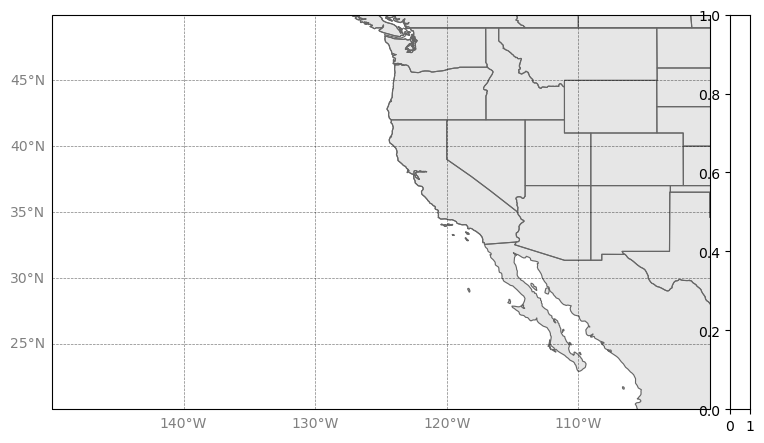

In [12]:
## test draw_basemap func
draw_basemap(ext1, datacrs, mapcrs, xticks, yticks);

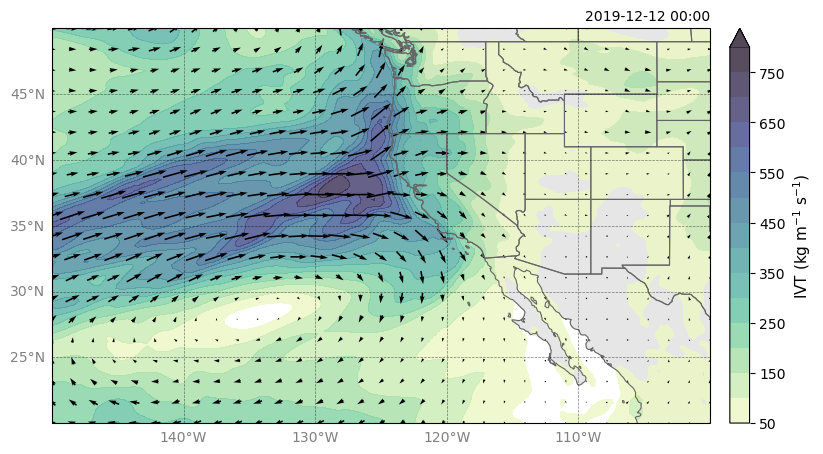

In [13]:
## test first timestep
_, ax, axgr = draw_basemap(ext1, datacrs, mapcrs, xticks, yticks)
# plot the variables
VO1 = DS[var1].values[0]
# VO2 = DS[var2].values[0]
VO3 = DS[var3].values[0]
uvec = DS[quvec].values[0]
vvec = DS[qvvec].values[0]

lons = DS.lon
lats = DS.lat

units = DS[var1].units
units2 = DS[var3].units
# Set title based on long name and current time step
ts = pd.to_datetime(str(DS.time.values[0])).strftime("%Y-%m-%d %H:%M")

# # Add contour plot (line)
# cs = ax.contour(lons, lats, VO2, transform=datacrs,
#                 levels=clevs2, colors='grey', 
#                 linewidths=0.7, linestyles='solid', zorder=10)
# kw_clabels = {'fontsize': 8, 
#               'inline': True, 
#               'inline_spacing': 10, 
#               'fmt': '%i',
#               'rightside_up': True, 
#               'use_clabeltext': True}
# plt.clabel(cs, **kw_clabels)

# # Add contour plot (shaded precip)
# cf2 = ax.contourf(lons, lats, VO3, 
#                   transform=datacrs, cmap=cmap3, 
#                   levels=clevs3, zorder=5, 
#                   extend='max', alpha=0.5)

# Add contour plot (shaded)
cf = ax.contourf(lons, lats, VO1, 
                 transform=datacrs, cmap=cmap1, 
                 levels=clevs1, zorder=0, 
                 extend='max', alpha=0.8)

# Wind barbs / vectors 
Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=regrid_q, pivot='middle',
              angles='xy', scale_units='xy', scale=300, units='xy')

# Colorbar (single)
cb = _.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label(units, fontsize=11)
cb.ax.tick_params(labelsize=10)

# add title
ax.set_title(ts, fontsize=10, loc='right')

plt.show()

In [14]:
def draw(frame, ax, axgr, add_colorbar=True):
    '''add the shaded and line contours, add the colormap'''
    # Clear current axis to overplot next time step
    ax.clear() # this works but removes the basemap!!
    ## hack - add this in here so it keeps basemap info
    ax.set_extent(ext1, crs=datacrs)

    # Add map features (continents and country borders)
    ax.add_feature(cfeature.LAND, facecolor='0.9')      
    ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
    ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

    # add in meridians and parallels
    gl = ax.gridlines(crs=datacrs, draw_labels=True,
                      linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.bottom_labels = True
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'gray'}
    
    ### Now let's plot our data!
    # values to plot
    VO1 = DS[var1].values[frame]
    # VO2 = DS[var2].values[frame]
    VO3 = DS[var3].values[frame]
    uvec = DS[quvec].values[frame]
    vvec = DS[qvvec].values[frame]
    # lats and lons
    lons = DS.lon
    lats = DS.lat
    # units for cmap
    units = DS[var1].units
    # Set title based on long name and current time step
    ts = pd.to_datetime(str(DS.time.values[frame])).strftime("%Y-%m-%d %H:%M")
    
    # # Add contour plot (line)
    # cs = ax.contour(lons, lats, VO2, transform=datacrs,
    #                 levels=clevs2, colors='grey', 
    #                 linewidths=0.7, linestyles='solid', zorder=10)
    # kw_clabels = {'fontsize': 8, 
    #               'inline': True, 
    #               'inline_spacing': 10, 
    #               'fmt': '%i',
    #               'rightside_up': True, 
    #               'use_clabeltext': True}
    # plt.clabel(cs, **kw_clabels)

    # Add contour plot (shaded precip)
    cf2 = ax.contourf(lons, lats, VO3, 
                      transform=datacrs, cmap=cmap3, 
                      levels=clevs3, zorder=5, 
                      extend='max', alpha=0.5)

    # Add contour plot (shaded)
    cf = ax.contourf(lons, lats, VO1, 
                     transform=datacrs, cmap=cmap1, 
                     levels=clevs1, zorder=0, 
                     extend='max', alpha=0.8)
    
    # Wind barbs / vectors 
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=regrid_q, pivot='middle',
                  angles='xy', scale_units='xy', scale=250, units='xy')
    
    # add title
    ax.set_title(ts, fontsize=10, loc='right')
    
    if add_colorbar == True:
        # Colorbar (single)
        cb = _.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
        cb.set_label(units, fontsize=11)
        cb.ax.tick_params(labelsize=10)
    
    
    return cf


def init():
    '''Draw initial frame'''
    return draw(0, ax, axgr, add_colorbar=True)


def animate(frame):
    '''Draw current frame'''
    return draw(frame, ax, axgr, add_colorbar=False)

In [15]:
## now create animation
fig, ax, axgr = draw_basemap(ext1, datacrs, mapcrs, xticks, yticks)

frames = DS.time.size        # Number of frames

ani = animation.FuncAnimation(fig, animate, frames, interval=0.01, blit=False,
                              init_func=init, repeat=False)
ani.save('../figs/{0}.gif'.format(figname), writer=animation.FFMpegWriter(fps=8))
plt.close(fig)